In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
import pandas as pd
from skimage import img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.measure import find_contours
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

### ABCF 이미지 로드

In [29]:
def show_image(image, title='Image'):
    if image is not None:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

In [30]:
def show_image_new(image, title='Image'):
    # 이미지를 uint8 형식으로 변환
    image_uint8 = (image * 255).astype(np.uint8)
    
    # 이미지 출력
    if image_uint8 is not None:
        plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print("이미지를 불러올 수 없습니다.")

In [31]:
def load_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    images = {}
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        images[image_file] = image_path
    return images

In [35]:
def load_images_in_folders(folders):
    images_in_folders = {}
    for folder_name, folder_path in folders.items():
        images_in_folders[folder_name] = load_images_in_folder(folder_path)
    return images_in_folders


In [38]:
folder_A = "datsset/A"
folder_B = "datsset/B"
folder_C = "datsset/C"
folder_F = "datsset/F"
folders = {
    'A': folder_A,
    'B': folder_B,
    'C': folder_C,
    'F': folder_F
}

In [39]:
images_in_folders = load_images_in_folders(folders)

In [40]:
images_in_folders

{'A': {'setimg6_sb_381_Liniya 1id61_2393.png': 'datsset/A/setimg6_sb_381_Liniya 1id61_2393.png',
  'Liniya 1id331_6385.png': 'datsset/A/Liniya 1id331_6385.png',
  'setimg6_sb_400_Liniya 1id68_2470.png': 'datsset/A/setimg6_sb_400_Liniya 1id68_2470.png',
  'setimg6_sb_354_Liniya 1id53_2044.png': 'datsset/A/setimg6_sb_354_Liniya 1id53_2044.png',
  'setimg5_labeling_196_Liniya 1id85_2227.png': 'datsset/A/setimg5_labeling_196_Liniya 1id85_2227.png',
  'setimg6_sb_247_Liniya 1id15_835.png': 'datsset/A/setimg6_sb_247_Liniya 1id15_835.png',
  'setimg5_labeling_194_Liniya 1id49_1451.png': 'datsset/A/setimg5_labeling_194_Liniya 1id49_1451.png',
  'setimg6_sb_379_Liniya 1id61_2372.png': 'datsset/A/setimg6_sb_379_Liniya 1id61_2372.png',
  'setimg6_sb_278_Liniya 1id23_902.png': 'datsset/A/setimg6_sb_278_Liniya 1id23_902.png',
  'setimg4_labelimg_20_Liniya 1id271_5134.png': 'datsset/A/setimg4_labelimg_20_Liniya 1id271_5134.png',
  'setimg6_sb_305_Liniya 1id2_460.png': 'datsset/A/setimg6_sb_305_Liniy

In [45]:
contour_folder = "contours_small_mopol"
os.makedirs(contour_folder, exist_ok=True)

In [67]:
import cv2
import numpy as np
from scipy.signal import find_peaks

def mopol(image_path):
    """
    주어진 이미지 경로에서 이미지를 불러오고 전처리하여 이진화된 이미지를 반환합니다.
    이미지의 히스토그램을 분석하여 주요 피크를 찾아 이진화를 수행합니다.
    
    Args:
        image_path (str): 이미지 파일의 경로.
    
    Returns:
        processed_image (numpy.ndarray): 전처리된 이진화 이미지.
        original_image (numpy.ndarray): 원본 그레이스케일 이미지.
        overlay_image (numpy.ndarray): 히스토그램 기반 마스크 적용 후 원본 이미지.
    """
    
    # 이미지 불러오기
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Error: Unable to read image at {image_path}")

    # 히스토그램 계산
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # 히스토그램의 피크 계산
    peaks, _ = find_peaks(hist.flatten(), distance=20, height=50)

    if len(peaks) > 1:
        # 피크 값 가져오기
        peak_values = peaks[np.argsort(hist[peaks], axis=0)][-2:]

        # 피크 값들을 기준으로 픽셀 값을 두 범주로 나누기
        thresholds = np.sort(peak_values.flatten())

        # 선택된 피크 값들의 빈도수를 비교하여 낮은 픽셀 값이 더 많은지 확인
        if hist[thresholds[0]][0] > hist[thresholds[1]][0]:
            lower_mid_value = thresholds[0]
        else:
            lower_mid_value = (thresholds[0] + thresholds[1]) // 2
    elif len(peaks) == 1:
        # 피크가 하나일 경우 해당 피크 값 이상을 흰색으로 설정
        lower_mid_value = peaks[0]
    else:
        # 피크가 없는 경우, 기본값으로 이미지의 중간 밝기를 설정
        lower_mid_value = 128

    # 중간 값과 두 피크 값 중 낮은 값의 중간 값 이상의 픽셀을 흰색으로 설정
    processed_image = np.zeros_like(image)
    processed_image[(image >= lower_mid_value)] = 255

    # 바이너리화
    _, binary_image = cv2.threshold(processed_image, lower_mid_value, 255, cv2.THRESH_BINARY)

    # 모폴로지 연산을 통해 노이즈를 제거
    kernel = np.ones((1, 1), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

    # 바이너리화하지 않은 이미지에서 lower_mid_value 이상인 픽셀을 노란색으로 표시
    colored_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colored_image[image >= lower_mid_value] = [255, 255, 0]

    # 필터링된 이미지를 흰색으로 표시
    lane_image = np.zeros_like(image)
    lane_image[dilated_image == 255] = 255

    # 바이너리화하지 않은 이미지와 필터링된 이미지를 오버랩
    overlay_image = cv2.addWeighted(colored_image, 0.7, cv2.cvtColor(lane_image, cv2.COLOR_GRAY2BGR), 0.3, 0)

    return dilated_image, image, overlay_image


In [68]:
mopol_folder = "mopol_image"
contour_folder = "contour_image"
comparison_folder = "mopol_contour_comparison"

os.makedirs(mopol_folder, exist_ok=True)
os.makedirs(contour_folder, exist_ok=True)
os.makedirs(comparison_folder, exist_ok=True)

In [69]:
# 레이블별로 이미지 처리
for label, images in images_in_folders.items():
    for image_name, image_path in images.items():
        try:
            # 모폴 전처리 및 이진화 이미지 생성
            binary, original_gray, overlay_image = mopol(image_path)
        except FileNotFoundError as e:
            print(f"Warning: {image_path} 이미지를 읽을 수 없습니다. 에러: {e}")
            continue

        # 모폴로지 연산 이미지 저장
        mopol_image_path = os.path.join(mopol_folder, f"{label}_{image_name}")
        cv2.imwrite(mopol_image_path, overlay_image)
        print(f"Saved mopol image at {mopol_image_path}")

        # 컨투어 검출
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 원본 이미지를 컬러로 변환
        contour_image = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2BGR)

        # 모든 컨투어 그리기
        for contour in contours:
            cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        
        # 컨투어 이미지 저장 경로 설정
        contour_image_path = os.path.join(contour_folder, f"{label}_{image_name}")
        cv2.imwrite(contour_image_path, contour_image)
        print(f"Processed and saved contour image at {contour_image_path}")

        # 레이블별 한 장씩 비교 이미지 생성
        if label in ['A', 'B', 'C', 'F']:
            # 비교 이미지 생성 (위: 모폴, 아래: 컨투어)
            comparison_image = np.vstack((overlay_image, contour_image))

            # 비교 이미지 저장 경로 설정
            comparison_image_path = os.path.join(comparison_folder, f"{label}_{image_name}")
            cv2.imwrite(comparison_image_path, comparison_image)
            print(f"Saved comparison image at {comparison_image_path}")

Saved mopol image at mopol_image/A_setimg6_sb_381_Liniya 1id61_2393.png
Processed and saved contour image at contour_image/A_setimg6_sb_381_Liniya 1id61_2393.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_381_Liniya 1id61_2393.png
Saved mopol image at mopol_image/A_Liniya 1id331_6385.png
Processed and saved contour image at contour_image/A_Liniya 1id331_6385.png
Saved comparison image at mopol_contour_comparison/A_Liniya 1id331_6385.png
Saved mopol image at mopol_image/A_setimg6_sb_400_Liniya 1id68_2470.png
Processed and saved contour image at contour_image/A_setimg6_sb_400_Liniya 1id68_2470.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_400_Liniya 1id68_2470.png
Saved mopol image at mopol_image/A_setimg6_sb_354_Liniya 1id53_2044.png
Processed and saved contour image at contour_image/A_setimg6_sb_354_Liniya 1id53_2044.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_354_Liniya 1id53_2044.png
Saved mopol image at mopol_image/A

Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_12_Liniya 1id256_4797.png
Saved mopol image at mopol_image/A_setimg6_sb_242_Liniya 1id15_805.png
Processed and saved contour image at contour_image/A_setimg6_sb_242_Liniya 1id15_805.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_242_Liniya 1id15_805.png
Saved mopol image at mopol_image/A_setimg6_sb_308_Liniya 1id3_106.png
Processed and saved contour image at contour_image/A_setimg6_sb_308_Liniya 1id3_106.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_308_Liniya 1id3_106.png
Saved mopol image at mopol_image/A_setimg6_sb_260_Liniya 1id15_861.png
Processed and saved contour image at contour_image/A_setimg6_sb_260_Liniya 1id15_861.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_260_Liniya 1id15_861.png
Saved mopol image at mopol_image/A_setimg6_sb_383_Liniya 1id61_2415.png
Processed and saved contour image at contour_image/A_setimg6_sb_383_Liniya 1id61_2415.pn

Saved comparison image at mopol_contour_comparison/A_setimg6_sb_413_Liniya 1id79_2778.png
Saved mopol image at mopol_image/A_setimg5_labeling_197_Liniya 1id93_3053.png
Processed and saved contour image at contour_image/A_setimg5_labeling_197_Liniya 1id93_3053.png
Saved comparison image at mopol_contour_comparison/A_setimg5_labeling_197_Liniya 1id93_3053.png
Saved mopol image at mopol_image/A_Liniya 1id331_6387.png
Processed and saved contour image at contour_image/A_Liniya 1id331_6387.png
Saved comparison image at mopol_contour_comparison/A_Liniya 1id331_6387.png
Saved mopol image at mopol_image/A_setimg6_sb_414_Liniya 1id79_2786.png
Processed and saved contour image at contour_image/A_setimg6_sb_414_Liniya 1id79_2786.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_414_Liniya 1id79_2786.png
Saved mopol image at mopol_image/A_setimg6_sb_350_Liniya 1id45_1769.png
Processed and saved contour image at contour_image/A_setimg6_sb_350_Liniya 1id45_1769.png
Saved comparison

Saved mopol image at mopol_image/A_setimg6_sb_230_Liniya 1id13_775.png
Processed and saved contour image at contour_image/A_setimg6_sb_230_Liniya 1id13_775.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_230_Liniya 1id13_775.png
Saved mopol image at mopol_image/A_setimg6_sb_279_Liniya 1id23_904.png
Processed and saved contour image at contour_image/A_setimg6_sb_279_Liniya 1id23_904.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_279_Liniya 1id23_904.png
Saved mopol image at mopol_image/A_setimg6_sb_243_Liniya 1id15_809.png
Processed and saved contour image at contour_image/A_setimg6_sb_243_Liniya 1id15_809.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_243_Liniya 1id15_809.png
Saved mopol image at mopol_image/A_setimg4_labelimg_7_Liniya 1id217_4410.png
Processed and saved contour image at contour_image/A_setimg4_labelimg_7_Liniya 1id217_4410.png
Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_7_Liniya 1i

Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_21_Liniya 1id271_5165.png
Saved mopol image at mopol_image/A_setimg6_sb_423_Liniya 1id79_2858.png
Processed and saved contour image at contour_image/A_setimg6_sb_423_Liniya 1id79_2858.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_423_Liniya 1id79_2858.png
Saved mopol image at mopol_image/A_setimg4_labelimg_48_Liniya 1id41_1110.png
Processed and saved contour image at contour_image/A_setimg4_labelimg_48_Liniya 1id41_1110.png
Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_48_Liniya 1id41_1110.png
Saved mopol image at mopol_image/A_setimg4_labelimg_5_Liniya 1id180_3965.png
Processed and saved contour image at contour_image/A_setimg4_labelimg_5_Liniya 1id180_3965.png
Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_5_Liniya 1id180_3965.png
Saved mopol image at mopol_image/A_setimg4_labelimg_32_Liniya 1id320_6674.png
Processed and saved contour image at con

Saved mopol image at mopol_image/A_setimg6_sb_346_Liniya 1id45_1709.png
Processed and saved contour image at contour_image/A_setimg6_sb_346_Liniya 1id45_1709.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_346_Liniya 1id45_1709.png
Saved mopol image at mopol_image/A_setimg6_sb_372_Liniya 1id61_2309.png
Processed and saved contour image at contour_image/A_setimg6_sb_372_Liniya 1id61_2309.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_372_Liniya 1id61_2309.png
Saved mopol image at mopol_image/A_setimg6_sb_367_Liniya 1id5_153.png
Processed and saved contour image at contour_image/A_setimg6_sb_367_Liniya 1id5_153.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_367_Liniya 1id5_153.png
Saved mopol image at mopol_image/A_setimg4_labelimg_26_Liniya 1id2_62.png
Processed and saved contour image at contour_image/A_setimg4_labelimg_26_Liniya 1id2_62.png
Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_26_Liniya 1id2

Saved comparison image at mopol_contour_comparison/A_setimg6_sb_325_Liniya 1id3_34.png
Saved mopol image at mopol_image/A_setimg6_sb_272_Liniya 1id23_884.png
Processed and saved contour image at contour_image/A_setimg6_sb_272_Liniya 1id23_884.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_272_Liniya 1id23_884.png
Saved mopol image at mopol_image/A_setimg6_sb_352_Liniya 1id45_1806.png
Processed and saved contour image at contour_image/A_setimg6_sb_352_Liniya 1id45_1806.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_352_Liniya 1id45_1806.png
Saved mopol image at mopol_image/A_setimg6_sb_282_Liniya 1id23_913.png
Processed and saved contour image at contour_image/A_setimg6_sb_282_Liniya 1id23_913.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_282_Liniya 1id23_913.png
Saved mopol image at mopol_image/A_setimg6_sb_403_Liniya 1id70_2774.png
Processed and saved contour image at contour_image/A_setimg6_sb_403_Liniya 1id70_2774.png
S

Saved comparison image at mopol_contour_comparison/A_setimg6_sb_286_Liniya 1id23_925.png
Saved mopol image at mopol_image/A_setimg4_labelimg_50_Liniya 1id74_2023.png
Processed and saved contour image at contour_image/A_setimg4_labelimg_50_Liniya 1id74_2023.png
Saved comparison image at mopol_contour_comparison/A_setimg4_labelimg_50_Liniya 1id74_2023.png
Saved mopol image at mopol_image/A_setimg6_sb_390_Liniya 1id66_2573.png
Processed and saved contour image at contour_image/A_setimg6_sb_390_Liniya 1id66_2573.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_390_Liniya 1id66_2573.png
Saved mopol image at mopol_image/A_setimg6_sb_211_Liniya 1id12_663.png
Processed and saved contour image at contour_image/A_setimg6_sb_211_Liniya 1id12_663.png
Saved comparison image at mopol_contour_comparison/A_setimg6_sb_211_Liniya 1id12_663.png
Saved mopol image at mopol_image/A_setimg6_sb_315_Liniya 1id3_151.png
Processed and saved contour image at contour_image/A_setimg6_sb_315_Liniy

Saved mopol image at mopol_image/B_setimg6_sb_502_Liniya 1id56_2190.png
Processed and saved contour image at contour_image/B_setimg6_sb_502_Liniya 1id56_2190.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_502_Liniya 1id56_2190.png
Saved mopol image at mopol_image/B_setimg4_labelimg_69_Liniya 1id219_4463.png
Processed and saved contour image at contour_image/B_setimg4_labelimg_69_Liniya 1id219_4463.png
Saved comparison image at mopol_contour_comparison/B_setimg4_labelimg_69_Liniya 1id219_4463.png
Saved mopol image at mopol_image/B_setimg6_sb_428_Liniya 1id125_4034.png
Processed and saved contour image at contour_image/B_setimg6_sb_428_Liniya 1id125_4034.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_428_Liniya 1id125_4034.png
Saved mopol image at mopol_image/B_setimg6_sb_520_Liniya 1id70_2902.png
Processed and saved contour image at contour_image/B_setimg6_sb_520_Liniya 1id70_2902.png
Saved comparison image at mopol_contour_comparison/B_setimg6_

Saved comparison image at mopol_contour_comparison/B_setimg4_labelimg_56_Liniya 1id146_3269.png
Saved mopol image at mopol_image/B_setimg6_sb_439_Liniya 1id17_878.png
Processed and saved contour image at contour_image/B_setimg6_sb_439_Liniya 1id17_878.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_439_Liniya 1id17_878.png
Saved mopol image at mopol_image/B_setimg6_sb_481_Liniya 1id42_1842.png
Processed and saved contour image at contour_image/B_setimg6_sb_481_Liniya 1id42_1842.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_481_Liniya 1id42_1842.png
Saved mopol image at mopol_image/B_setimg4_labelimg_65_Liniya 1id181_4041.png
Processed and saved contour image at contour_image/B_setimg4_labelimg_65_Liniya 1id181_4041.png
Saved comparison image at mopol_contour_comparison/B_setimg4_labelimg_65_Liniya 1id181_4041.png
Saved mopol image at mopol_image/B_setimg4_labelimg_57_Liniya 1id146_3328.png
Processed and saved contour image at contour_image/B_se

Saved mopol image at mopol_image/B_setimg4_labelimg_88_Liniya 1id296_5843.png
Processed and saved contour image at contour_image/B_setimg4_labelimg_88_Liniya 1id296_5843.png
Saved comparison image at mopol_contour_comparison/B_setimg4_labelimg_88_Liniya 1id296_5843.png
Saved mopol image at mopol_image/B_setimg4_labelimg_71_Liniya 1id226_4571.png
Processed and saved contour image at contour_image/B_setimg4_labelimg_71_Liniya 1id226_4571.png
Saved comparison image at mopol_contour_comparison/B_setimg4_labelimg_71_Liniya 1id226_4571.png
Saved mopol image at mopol_image/B_setimg6_sb_429_Liniya 1id125_4036.png
Processed and saved contour image at contour_image/B_setimg6_sb_429_Liniya 1id125_4036.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_429_Liniya 1id125_4036.png
Saved mopol image at mopol_image/B_setimg6_sb_524_Liniya 1id76_2961.png
Processed and saved contour image at contour_image/B_setimg6_sb_524_Liniya 1id76_2961.png
Saved comparison image at mopol_contour_com

Saved mopol image at mopol_image/B_setimg6_sb_509_Liniya 1id56_2227.png
Processed and saved contour image at contour_image/B_setimg6_sb_509_Liniya 1id56_2227.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_509_Liniya 1id56_2227.png
Saved mopol image at mopol_image/B_setimg6_sb_486_Liniya 1id42_1871.png
Processed and saved contour image at contour_image/B_setimg6_sb_486_Liniya 1id42_1871.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_486_Liniya 1id42_1871.png
Saved mopol image at mopol_image/B_setimg6_sb_515_Liniya 1id66_2677.png
Processed and saved contour image at contour_image/B_setimg6_sb_515_Liniya 1id66_2677.png
Saved comparison image at mopol_contour_comparison/B_setimg6_sb_515_Liniya 1id66_2677.png
Saved mopol image at mopol_image/C_setimg6_sb_556_Liniya 1id34_1340.png
Processed and saved contour image at contour_image/C_setimg6_sb_556_Liniya 1id34_1340.png
Saved comparison image at mopol_contour_comparison/C_setimg6_sb_556_Liniya 1id34_1

Saved mopol image at mopol_image/C_setimg6_sb_576_Liniya 1id36_1460.png
Processed and saved contour image at contour_image/C_setimg6_sb_576_Liniya 1id36_1460.png
Saved comparison image at mopol_contour_comparison/C_setimg6_sb_576_Liniya 1id36_1460.png
Saved mopol image at mopol_image/C_setimg6_sb_549_Liniya 1id106_3804.png
Processed and saved contour image at contour_image/C_setimg6_sb_549_Liniya 1id106_3804.png
Saved comparison image at mopol_contour_comparison/C_setimg6_sb_549_Liniya 1id106_3804.png
Saved mopol image at mopol_image/C_setimg4_labelimg_142_Liniya 1id59_1859.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_142_Liniya 1id59_1859.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_142_Liniya 1id59_1859.png
Saved mopol image at mopol_image/C_setimg4_labelimg_137_Liniya 1id349_7053.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_137_Liniya 1id349_7053.png
Saved comparison image at mopol_contour_compari

Processed and saved contour image at contour_image/C_setimg4_labelimg_146_Liniya 1id65_1975.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_146_Liniya 1id65_1975.png
Saved mopol image at mopol_image/C_setimg4_labelimg_115_Liniya 1id319_6548.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_115_Liniya 1id319_6548.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_115_Liniya 1id319_6548.png
Saved mopol image at mopol_image/C_setimg4_labelimg_105_Liniya 1id154_3425.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_105_Liniya 1id154_3425.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_105_Liniya 1id154_3425.png
Saved mopol image at mopol_image/C_setimg6_sb_579_Liniya 1id36_1474.png
Processed and saved contour image at contour_image/C_setimg6_sb_579_Liniya 1id36_1474.png
Saved comparison image at mopol_contour_comparison/C_setimg6_sb_579_Liniya 1id36_1474.png
Saved mopo

Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_101_Liniya 1id105_3013.png
Saved mopol image at mopol_image/C_setimg6_sb_561_Liniya 1id34_1363.png
Processed and saved contour image at contour_image/C_setimg6_sb_561_Liniya 1id34_1363.png
Saved comparison image at mopol_contour_comparison/C_setimg6_sb_561_Liniya 1id34_1363.png
Saved mopol image at mopol_image/C_setimg4_labelimg_96_Liniya 1id105_2800.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_96_Liniya 1id105_2800.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_96_Liniya 1id105_2800.png
Saved mopol image at mopol_image/C_setimg4_labelimg_99_Liniya 1id105_2983.png
Processed and saved contour image at contour_image/C_setimg4_labelimg_99_Liniya 1id105_2983.png
Saved comparison image at mopol_contour_comparison/C_setimg4_labelimg_99_Liniya 1id105_2983.png
Saved mopol image at mopol_image/C_setimg4_labelimg_134_Liniya 1id349_7045.png
Processed and saved contour imag

Saved mopol image at mopol_image/F_setimg4_labelimg_169_Liniya 1id297_5858.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_169_Liniya 1id297_5858.png
Saved comparison image at mopol_contour_comparison/F_setimg4_labelimg_169_Liniya 1id297_5858.png
Saved mopol image at mopol_image/F_setimg4_labelimg_183_Liniya 1id303_6079.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_183_Liniya 1id303_6079.png
Saved comparison image at mopol_contour_comparison/F_setimg4_labelimg_183_Liniya 1id303_6079.png
Saved mopol image at mopol_image/F_setimg1_labelimg_1016_Liniya 1id514_9515.png
Processed and saved contour image at contour_image/F_setimg1_labelimg_1016_Liniya 1id514_9515.png
Saved comparison image at mopol_contour_comparison/F_setimg1_labelimg_1016_Liniya 1id514_9515.png
Saved mopol image at mopol_image/F_setimg4_labelimg_184_Liniya 1id325_6396.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_184_Liniya 1id325_6396.png
Sa

Saved comparison image at mopol_contour_comparison/F_Liniya 1id187_3577.png
Saved mopol image at mopol_image/F_setimg4_labelimg_154_Liniya 1id294_5931.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_154_Liniya 1id294_5931.png
Saved comparison image at mopol_contour_comparison/F_setimg4_labelimg_154_Liniya 1id294_5931.png
Saved mopol image at mopol_image/F_Liniya 1id326_8922.png
Processed and saved contour image at contour_image/F_Liniya 1id326_8922.png
Saved comparison image at mopol_contour_comparison/F_Liniya 1id326_8922.png
Saved mopol image at mopol_image/F_Liniya 1id93_2275.png
Processed and saved contour image at contour_image/F_Liniya 1id93_2275.png
Saved comparison image at mopol_contour_comparison/F_Liniya 1id93_2275.png
Saved mopol image at mopol_image/F_setimg1_labelimg_1000_Liniya 1id1_13.png
Processed and saved contour image at contour_image/F_setimg1_labelimg_1000_Liniya 1id1_13.png
Saved comparison image at mopol_contour_comparison/F_setimg1_lab

Saved comparison image at mopol_contour_comparison/F_setimg4_labelimg_179_Liniya 1id303_6051.png
Saved mopol image at mopol_image/F_Liniya 1id71_1362.png
Processed and saved contour image at contour_image/F_Liniya 1id71_1362.png
Saved comparison image at mopol_contour_comparison/F_Liniya 1id71_1362.png
Saved mopol image at mopol_image/F_Liniya 1id77_1626.png
Processed and saved contour image at contour_image/F_Liniya 1id77_1626.png
Saved comparison image at mopol_contour_comparison/F_Liniya 1id77_1626.png
Saved mopol image at mopol_image/F_setimg4_labelimg_149_Liniya 1id294_5899.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_149_Liniya 1id294_5899.png
Saved comparison image at mopol_contour_comparison/F_setimg4_labelimg_149_Liniya 1id294_5899.png
Saved mopol image at mopol_image/F_setimg4_labelimg_158_Liniya 1id294_5959.png
Processed and saved contour image at contour_image/F_setimg4_labelimg_158_Liniya 1id294_5959.png
Saved comparison image at mopol_contour_

### 결과 확인

In [77]:
import os
import cv2
import matplotlib.pyplot as plt

# 이미지 경로 설정
comparison_image_path = "mopol_contour_comparison"

# 레이블 목록
labels = ['A', 'B', 'C', 'F']

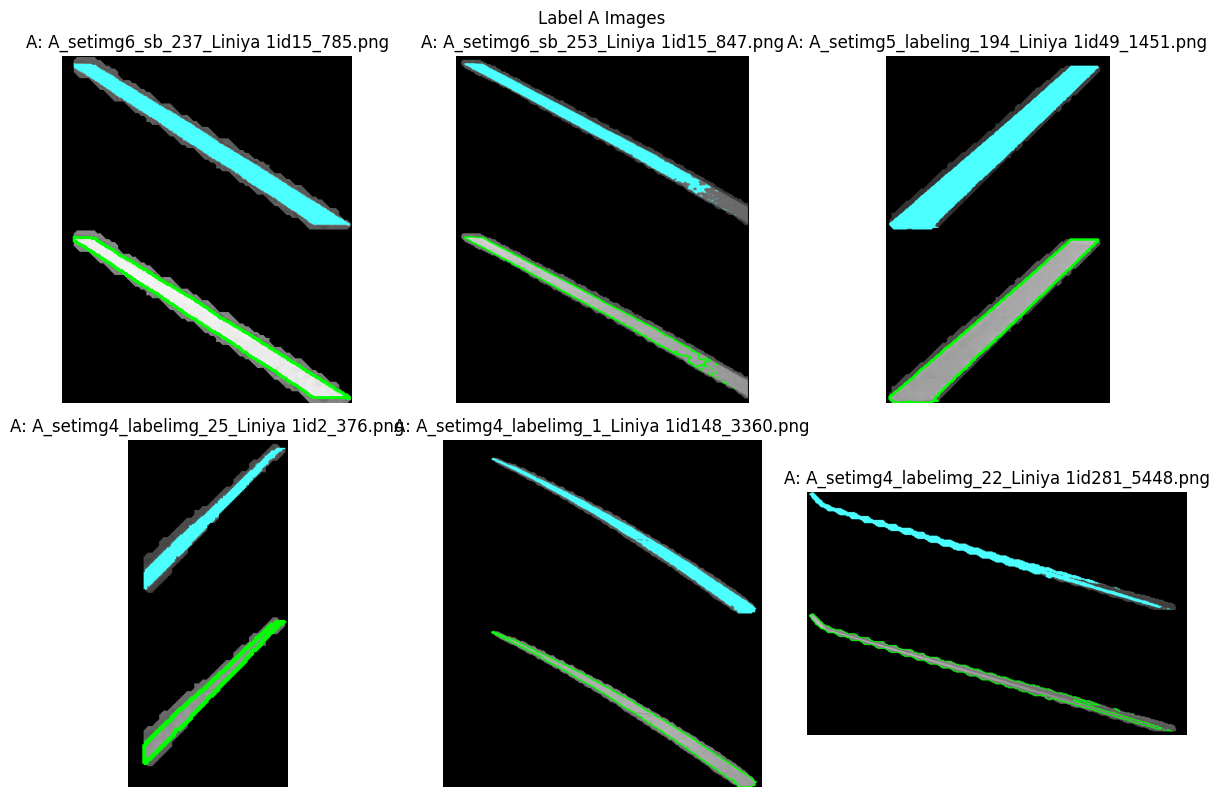

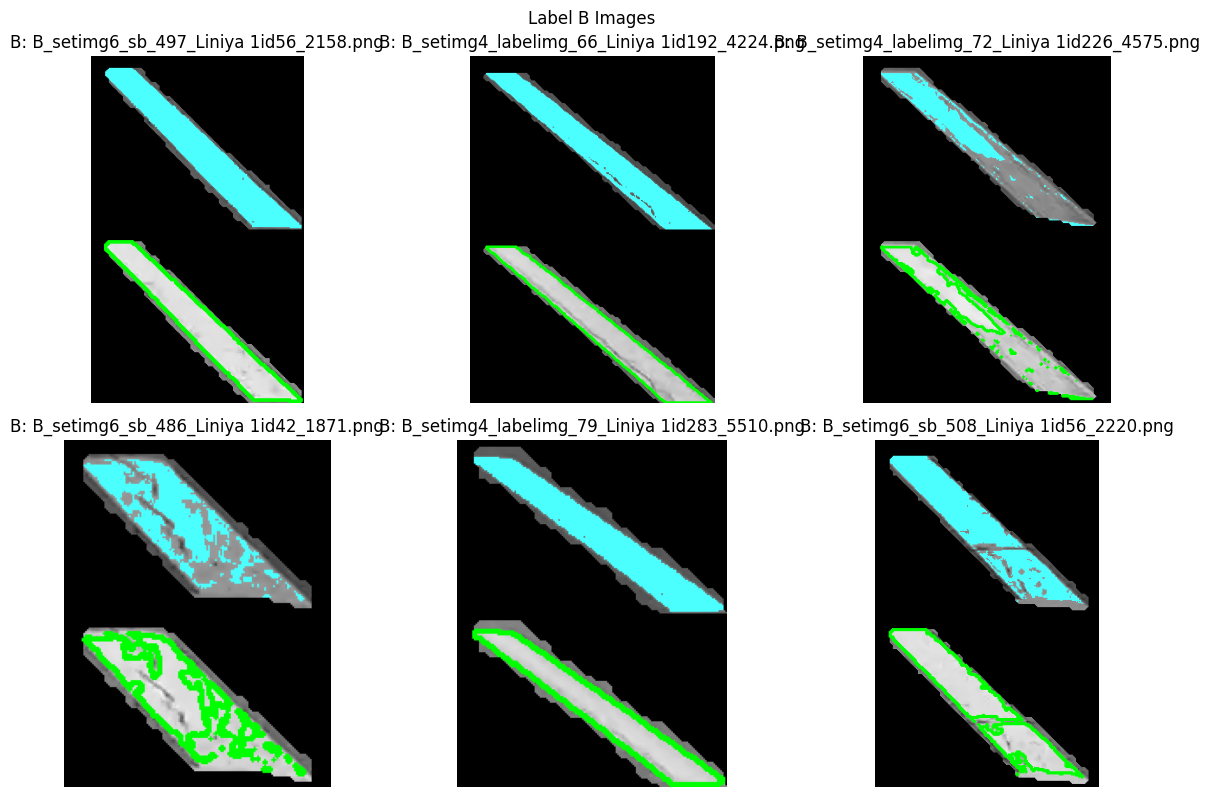

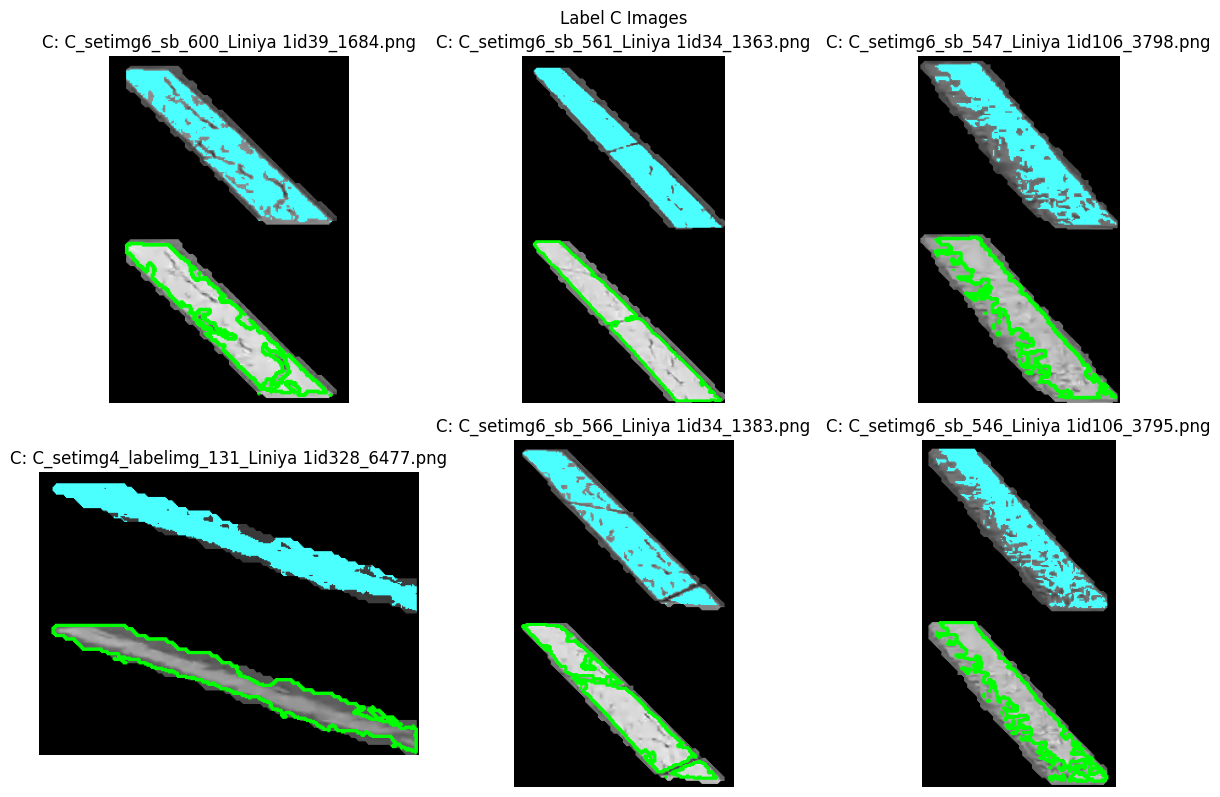

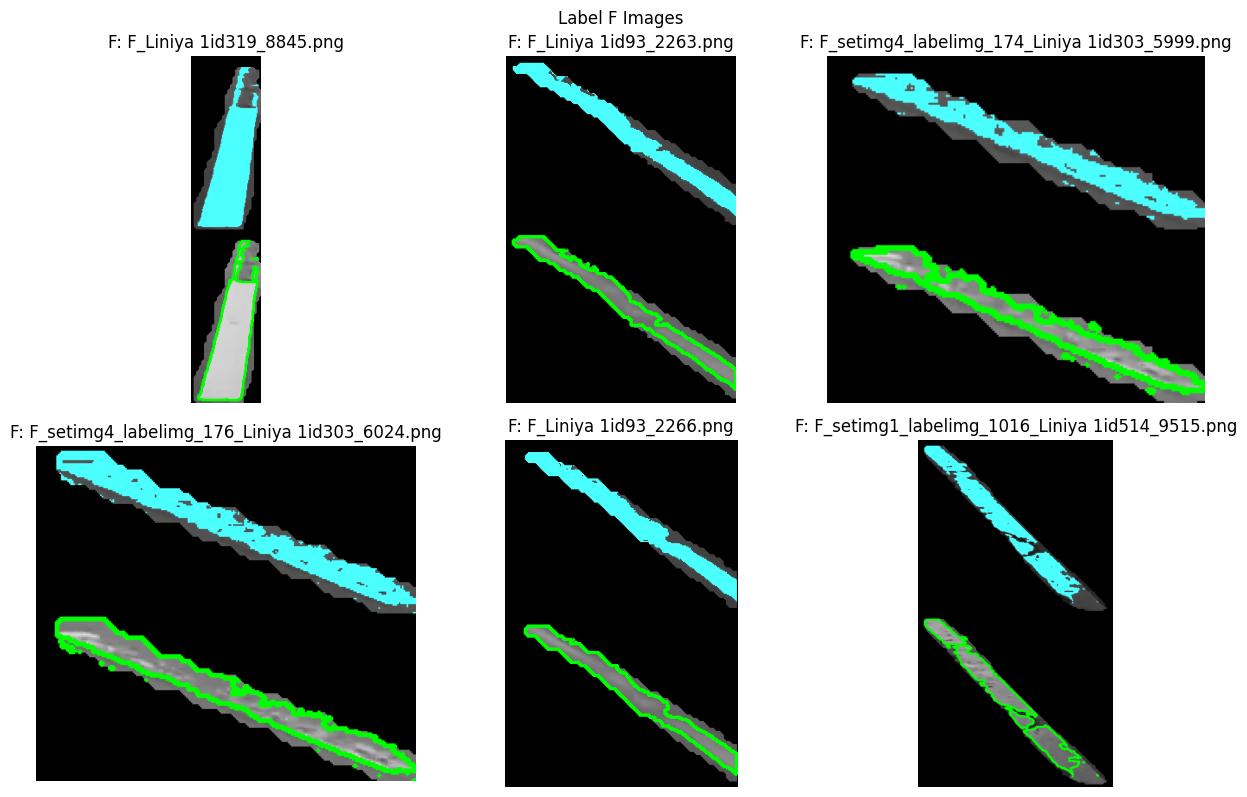

In [76]:
# 각 레이블별로 6장씩 이미지 출력
for label in labels:
    # 해당 레이블의 파일 목록 가져오기
    files = [f for f in os.listdir(comparison_image_path) if f.startswith(label) and f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 파일이 6개 이상일 때만 출력
    if len(files) >= 6:
        # 최대 6개의 파일을 선택
        selected_files = files[:6]
        
        # 이미지 출력
        plt.figure(figsize=(12, 12))
        
        for idx, file in enumerate(selected_files):
            image_file_path = os.path.join(comparison_image_path, file)
            image = cv2.imread(image_file_path)
            if image is not None:
                # OpenCV는 BGR 형식으로 이미지를 읽으므로, RGB 형식으로 변환
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # 이미지 표시
                plt.subplot(3, 3, idx + 1)
                plt.imshow(image)
                plt.title(f"{label}: {file}")
                plt.axis('off')
            else:
                print(f"Warning: {image_file_path} 이미지를 읽을 수 없습니다.")
        
        plt.suptitle(f"Label {label} Images")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: {label} 레이블에 대해 6개 이상의 이미지가 없습니다.")